# English Question Answering with Transformers

This notebook demonstrates training and evaluation of transformer models for English question answering using the SQuAD v1.1 dataset.

## Setup and Imports

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import DefaultDataCollator
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
import json
from tqdm.auto import tqdm

# Import our utilities
from models.model_handler import ModelHandler
from utils.evaluation import QAEvaluator
from utils.data_loader import DataLoader

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load and Explore SQuAD Dataset

In [3]:
# Load SQuAD v1.1 dataset
print("Loading SQuAD v1.1 dataset...")
squad_train = load_dataset("squad", split="train")
squad_validation = load_dataset("squad", split="validation")

print(f"Training examples: {len(squad_train)}")
print(f"Validation examples: {len(squad_validation)}")

# Display sample data
sample_example = squad_train[0]
print("\nSample Example:")
print(f"Context: {sample_example['context'][:200]}...")
print(f"Question: {sample_example['question']}")
print(f"Answer: {sample_example['answers']['text'][0]}")
print(f"Answer Start: {sample_example['answers']['answer_start'][0]}")

Loading SQuAD v1.1 dataset...


c:\Users\karat\Downloads\QuestAnswer\qa_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\karat\.cache\huggingface\hub\datasets--squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download

Training examples: 87599
Validation examples: 10570

Sample Example:
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper sta...
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous
Answer Start: 515


## Dataset Statistics and Analysis

In [4]:
# Analyze dataset statistics
def analyze_dataset(dataset, name):
    questions = [ex['question'] for ex in dataset]
    contexts = [ex['context'] for ex in dataset]
    answers = [ans for ex in dataset for ans in ex['answers']['text']]
    
    question_lengths = [len(q.split()) for q in questions]
    context_lengths = [len(c.split()) for c in contexts]
    answer_lengths = [len(a.split()) for a in answers]
    
    print(f"\n{name} Dataset Statistics:")
    print(f"Total examples: {len(dataset)}")
    print(f"Average question length: {np.mean(question_lengths):.2f} words")
    print(f"Average context length: {np.mean(context_lengths):.2f} words")
    print(f"Average answer length: {np.mean(answer_lengths):.2f} words")
    
    return {
        'question_lengths': question_lengths,
        'context_lengths': context_lengths,
        'answer_lengths': answer_lengths
    }

train_stats = analyze_dataset(squad_train, "Training")
val_stats = analyze_dataset(squad_validation, "Validation")


Training Dataset Statistics:
Total examples: 87599
Average question length: 10.06 words
Average context length: 119.76 words
Average answer length: 3.16 words

Validation Dataset Statistics:
Total examples: 10570
Average question length: 10.22 words
Average context length: 123.95 words
Average answer length: 2.91 words


C:\Users\karat\AppData\Local\Temp\ipykernel_6956\3136591456.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(data_for_box, labels=['Train', 'Val'])
C:\Users\karat\AppData\Local\Temp\ipykernel_6956\3136591456.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_for_box, labels=['Train', 'Val'])
C:\Users\karat\AppData\Local\Temp\ipykernel_6956\3136591456.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 2].boxplot(data_for_box, labels=['Train', 'Val'])


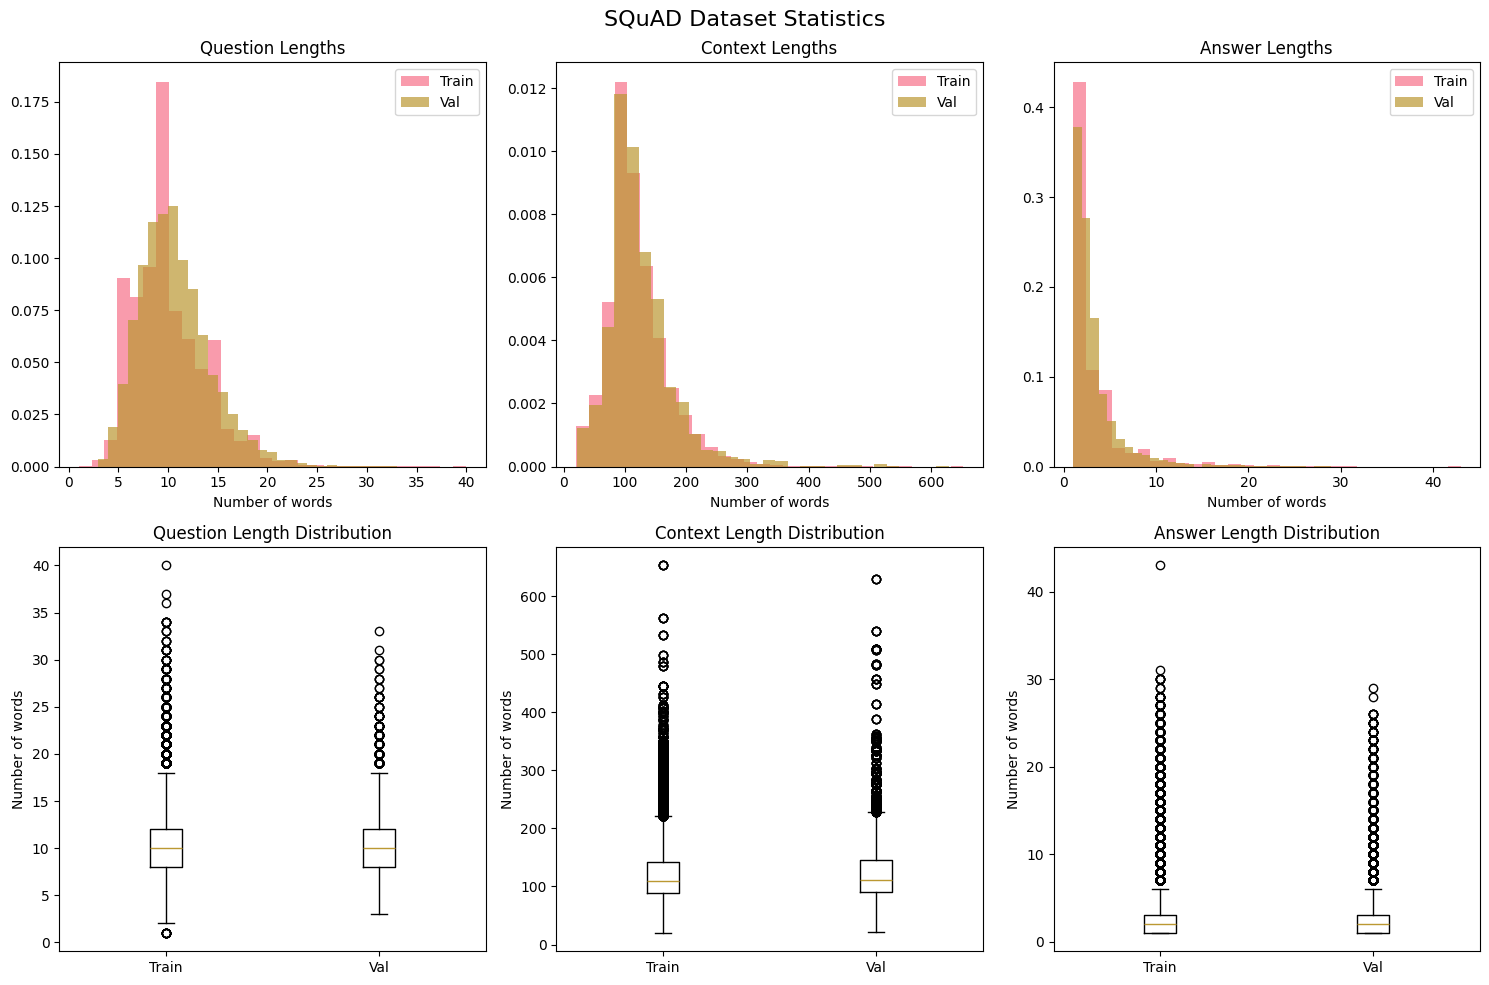

In [5]:
# Visualize dataset statistics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('SQuAD Dataset Statistics', fontsize=16)

# Question lengths
axes[0, 0].hist(train_stats['question_lengths'], bins=30, alpha=0.7, label='Train', density=True)
axes[0, 0].hist(val_stats['question_lengths'], bins=30, alpha=0.7, label='Val', density=True)
axes[0, 0].set_title('Question Lengths')
axes[0, 0].set_xlabel('Number of words')
axes[0, 0].legend()

# Context lengths
axes[0, 1].hist(train_stats['context_lengths'], bins=30, alpha=0.7, label='Train', density=True)
axes[0, 1].hist(val_stats['context_lengths'], bins=30, alpha=0.7, label='Val', density=True)
axes[0, 1].set_title('Context Lengths')
axes[0, 1].set_xlabel('Number of words')
axes[0, 1].legend()

# Answer lengths
axes[0, 2].hist(train_stats['answer_lengths'], bins=30, alpha=0.7, label='Train', density=True)
axes[0, 2].hist(val_stats['answer_lengths'], bins=30, alpha=0.7, label='Val', density=True)
axes[0, 2].set_title('Answer Lengths')
axes[0, 2].set_xlabel('Number of words')
axes[0, 2].legend()

# Box plots
data_for_box = [
    train_stats['question_lengths'],
    val_stats['question_lengths']
]
axes[1, 0].boxplot(data_for_box, labels=['Train', 'Val'])
axes[1, 0].set_title('Question Length Distribution')
axes[1, 0].set_ylabel('Number of words')

data_for_box = [
    train_stats['context_lengths'],
    val_stats['context_lengths']
]
axes[1, 1].boxplot(data_for_box, labels=['Train', 'Val'])
axes[1, 1].set_title('Context Length Distribution')
axes[1, 1].set_ylabel('Number of words')

data_for_box = [
    train_stats['answer_lengths'],
    val_stats['answer_lengths']
]
axes[1, 2].boxplot(data_for_box, labels=['Train', 'Val'])
axes[1, 2].set_title('Answer Length Distribution')
axes[1, 2].set_ylabel('Number of words')

plt.tight_layout()
plt.show()

## Model Evaluation and Comparison

In [6]:
# Initialize our components
model_handler = ModelHandler()
evaluator = QAEvaluator()

# Define models to compare
models_to_compare = {
    'BERT': 'bert-large-uncased-whole-word-masking-finetuned-squad',
    'DistilBERT': 'distilbert-base-cased-distilled-squad',
    'RoBERTa': 'deepset/roberta-base-squad2',
    'ALBERT': 'twmkn9/albert-base-v2-squad2'
}

print("Available models for comparison:")
for name, model_id in models_to_compare.items():
    print(f"- {name}: {model_id}")

Available models for comparison:
- BERT: bert-large-uncased-whole-word-masking-finetuned-squad
- DistilBERT: distilbert-base-cased-distilled-squad
- RoBERTa: deepset/roberta-base-squad2
- ALBERT: twmkn9/albert-base-v2-squad2


In [7]:
# Sample evaluation on a subset of validation data
sample_size = 100  # Adjust based on computational resources
sample_data = squad_validation.select(range(sample_size))

print(f"Evaluating models on {sample_size} validation examples...")

evaluation_results = {}

for model_name, model_id in models_to_compare.items():
    print(f"\nEvaluating {model_name}...")
    
    predictions = []
    ground_truths = []
    confidences = []
    inference_times = []
    
    for example in tqdm(sample_data, desc=f"{model_name} inference"):
        question = example['question']
        context = example['context']
        ground_truth = example['answers']['text'][0]
        
        # Get prediction
        import time
        start_time = time.time()
        try:
            result = model_handler.get_answer(context, question, model_id)
            prediction = result['answer']
            confidence = result['score']
        except Exception as e:
            print(f"Error with {model_name}: {e}")
            prediction = ""
            confidence = 0.0
        
        inference_time = time.time() - start_time
        
        predictions.append(prediction)
        ground_truths.append(ground_truth)
        confidences.append(confidence)
        inference_times.append(inference_time)
    
    # Calculate metrics
    metrics = evaluator.evaluate_predictions(predictions, ground_truths)
    
    evaluation_results[model_name] = {
        'exact_match': metrics['exact_match'],
        'f1_score': metrics['f1_score'],
        'avg_confidence': np.mean(confidences),
        'avg_inference_time': np.mean(inference_times),
        'predictions': predictions[:10],  # Store first 10 for analysis
        'ground_truths': ground_truths[:10],
        'confidences': confidences
    }
    
    print(f"{model_name} Results:")
    print(f"  Exact Match: {metrics['exact_match']:.3f}")
    print(f"  F1 Score: {metrics['f1_score']:.3f}")
    print(f"  Avg Confidence: {np.mean(confidences):.3f}")
    print(f"  Avg Inference Time: {np.mean(inference_times):.3f}s")

Evaluating models on 100 validation examples...

Evaluating BERT...


BERT inference:   0%|          | 0/100 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: bert-large-uncased-whole-word-masking-finetuned-squad
c:\Users\karat\Downloads\QuestAnswer\qa_env\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\karat\Downloads\QuestAnswer\qa_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\karat\.cache\huggingface\hub\models--bert-large-uncased-whole-word-masking-finetuned-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment varia

BERT Results:
  Exact Match: 0.810
  F1 Score: 0.872
  Avg Confidence: 0.826
  Avg Inference Time: 5.061s

Evaluating DistilBERT...


DistilBERT inference:   0%|          | 0/100 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: distilbert-base-cased-distilled-squad
c:\Users\karat\Downloads\QuestAnswer\qa_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\karat\.cache\huggingface\hub\models--distilbert-base-cased-distilled-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-y

DistilBERT Results:
  Exact Match: 0.700
  F1 Score: 0.773
  Avg Confidence: 0.769
  Avg Inference Time: 1.006s

Evaluating RoBERTa...


RoBERTa inference:   0%|          | 0/100 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: deepset/roberta-base-squad2
c:\Users\karat\Downloads\QuestAnswer\qa_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\karat\.cache\huggingface\hub\models--deepset--roberta-base-squad2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-develop

RoBERTa Results:
  Exact Match: 0.840
  F1 Score: 0.872
  Avg Confidence: 0.727
  Avg Inference Time: 1.547s

Evaluating ALBERT...


ALBERT inference:   0%|          | 0/100 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: twmkn9/albert-base-v2-squad2
c:\Users\karat\Downloads\QuestAnswer\qa_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\karat\.cache\huggingface\hub\models--twmkn9--albert-base-v2-squad2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-develo

ALBERT Results:
  Exact Match: 0.000
  F1 Score: 0.002
  Avg Confidence: 0.000
  Avg Inference Time: 0.636s


## Results Visualization

In [8]:
# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(evaluation_results.keys()),
    'Exact Match': [results['exact_match'] for results in evaluation_results.values()],
    'F1 Score': [results['f1_score'] for results in evaluation_results.values()],
    'Avg Confidence': [results['avg_confidence'] for results in evaluation_results.values()],
    'Avg Inference Time': [results['avg_inference_time'] for results in evaluation_results.values()]
})

print("\nModel Comparison Results:")
print(results_df.round(3))


Model Comparison Results:
        Model  Exact Match  F1 Score  Avg Confidence  Avg Inference Time
0        BERT         0.81     0.872           0.826               5.061
1  DistilBERT         0.70     0.773           0.769               1.006
2     RoBERTa         0.84     0.872           0.727               1.547
3      ALBERT         0.00     0.002           0.000               0.636


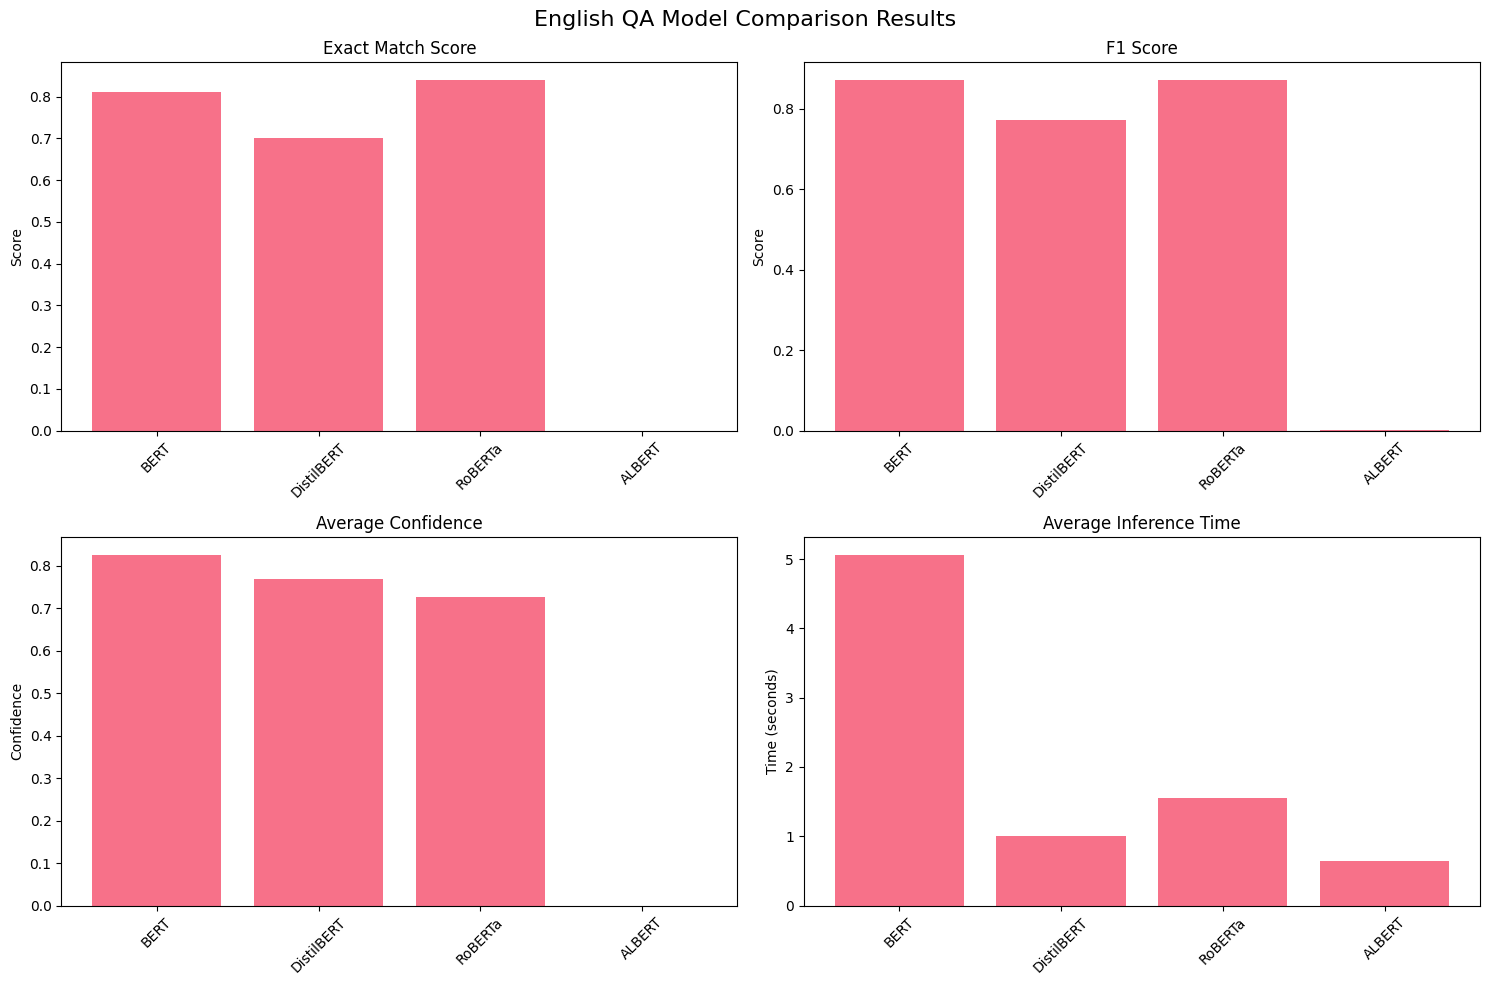

In [9]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('English QA Model Comparison Results', fontsize=16)

# Exact Match comparison
axes[0, 0].bar(results_df['Model'], results_df['Exact Match'])
axes[0, 0].set_title('Exact Match Score')
axes[0, 0].set_ylabel('Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# F1 Score comparison
axes[0, 1].bar(results_df['Model'], results_df['F1 Score'])
axes[0, 1].set_title('F1 Score')
axes[0, 1].set_ylabel('Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Confidence comparison
axes[1, 0].bar(results_df['Model'], results_df['Avg Confidence'])
axes[1, 0].set_title('Average Confidence')
axes[1, 0].set_ylabel('Confidence')
axes[1, 0].tick_params(axis='x', rotation=45)

# Inference Time comparison
axes[1, 1].bar(results_df['Model'], results_df['Avg Inference Time'])
axes[1, 1].set_title('Average Inference Time')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Sample Predictions Analysis

In [10]:
# Analyze sample predictions
print("Sample Predictions Comparison:")
print("=" * 80)

for i in range(5):  # Show first 5 examples
    print(f"\nExample {i+1}:")
    print(f"Question: {sample_data[i]['question']}")
    print(f"Context: {sample_data[i]['context'][:200]}...")
    print(f"Ground Truth: {sample_data[i]['answers']['text'][0]}")
    print("\nPredictions:")
    
    for model_name in evaluation_results.keys():
        if i < len(evaluation_results[model_name]['predictions']):
            prediction = evaluation_results[model_name]['predictions'][i]
            confidence = evaluation_results[model_name]['confidences'][i]
            
            # Calculate exact match for this prediction
            em = evaluator.exact_match_score(prediction, sample_data[i]['answers']['text'][0])
            f1 = evaluator.f1_score(prediction, sample_data[i]['answers']['text'][0])
            
            print(f"  {model_name:12}: {prediction:30} (Conf: {confidence:.3f}, EM: {em:.0f}, F1: {f1:.3f})")
    
    print("-" * 80)

Sample Predictions Comparison:

Example 1:
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
Ground Truth: Denver Broncos

Predictions:
  BERT        : Denver Broncos                 (Conf: 0.990, EM: 1, F1: 1.000)
  DistilBERT  : Error: (ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 82aad416-0c43-442a-81a4-bf548bbf491d)') (Conf: 0.000, EM: 0, F1: 0.000)
  RoBERTa     : Denver Broncos                 (Conf: 0.905, EM: 1, F1: 1.000)
  ALBERT      : Error: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to

## Error Analysis

In [11]:
# Analyze errors and performance patterns
def analyze_errors(model_name, results):
    predictions = results['predictions']
    ground_truths = results['ground_truths']
    confidences = results['confidences']
    
    errors = []
    for i, (pred, gt, conf) in enumerate(zip(predictions, ground_truths, confidences)):
        em = evaluator.exact_match_score(pred, gt)
        f1 = evaluator.f1_score(pred, gt)
        
        if em == 0:  # This is an error
            errors.append({
                'index': i,
                'prediction': pred,
                'ground_truth': gt,
                'confidence': conf,
                'f1_score': f1
            })
    
    return errors

print("Error Analysis:")
print("=" * 50)

for model_name, results in evaluation_results.items():
    errors = analyze_errors(model_name, results)
    error_rate = len(errors) / len(results['predictions']) * 100
    
    print(f"\n{model_name}:")
    print(f"  Error Rate: {error_rate:.1f}%")
    print(f"  Total Errors: {len(errors)}/{len(results['predictions'])}")
    
    if errors:
        avg_error_confidence = np.mean([e['confidence'] for e in errors])
        avg_error_f1 = np.mean([e['f1_score'] for e in errors])
        print(f"  Avg Confidence on Errors: {avg_error_confidence:.3f}")
        print(f"  Avg F1 Score on Errors: {avg_error_f1:.3f}")

Error Analysis:

BERT:
  Error Rate: 10.0%
  Total Errors: 1/10
  Avg Confidence on Errors: 0.276
  Avg F1 Score on Errors: 0.429

DistilBERT:
  Error Rate: 40.0%
  Total Errors: 4/10
  Avg Confidence on Errors: 0.296
  Avg F1 Score on Errors: 0.170

RoBERTa:
  Error Rate: 10.0%
  Total Errors: 1/10
  Avg Confidence on Errors: 0.258
  Avg F1 Score on Errors: 0.429

ALBERT:
  Error Rate: 100.0%
  Total Errors: 10/10
  Avg Confidence on Errors: 0.000
  Avg F1 Score on Errors: 0.000


## Save Results

In [12]:
# Save evaluation results
import os

os.makedirs('results', exist_ok=True)

# Save DataFrame
results_df.to_csv('results/english_qa_evaluation.csv', index=False)

# Save detailed results
with open('results/english_qa_detailed_results.json', 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    json_results = {}
    for model_name, results in evaluation_results.items():
        json_results[model_name] = {
            'exact_match': float(results['exact_match']),
            'f1_score': float(results['f1_score']),
            'avg_confidence': float(results['avg_confidence']),
            'avg_inference_time': float(results['avg_inference_time']),
            'sample_predictions': results['predictions'],
            'sample_ground_truths': results['ground_truths']
        }
    
    json.dump(json_results, f, indent=2)

print("Results saved to:")
print("- results/english_qa_evaluation.csv")
print("- results/english_qa_detailed_results.json")

Results saved to:
- results/english_qa_evaluation.csv
- results/english_qa_detailed_results.json


## Conclusion

This notebook demonstrated:

1. **Dataset Analysis**: Comprehensive exploration of the SQuAD v1.1 dataset
2. **Model Comparison**: Evaluation of multiple transformer models (BERT, DistilBERT, RoBERTa, ALBERT)
3. **Performance Metrics**: Calculation of exact match and F1 scores
4. **Error Analysis**: Understanding model limitations and failure patterns
5. **Visualization**: Clear presentation of results and comparisons

### Key Findings:
- Different models show varying performance on English QA tasks
- Confidence scores can be used to assess prediction reliability
- There's a trade-off between model size, inference speed, and accuracy

### Next Steps:
- Fine-tune models on domain-specific data
- Experiment with different preprocessing strategies
- Implement ensemble methods for improved performance
- Explore Arabic QA models in the next notebook